# Wexford wind data from MetEireann
I intend to create an LSTM model which predicts the wind speed based on historic data

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

#rain  - Precipitation (mm)
temp  - Air Temperature (C)
wetb  - Wet Bulb Temperature (C)
dewpt  - Dew Point Temperature (C)
vappr - Vapour Pressure (hPa)
rhum  - Relative Humidity (%)
msl   - Mean Sea Level Pressure (hPa)
wdsp  - Mean Wind Speed (kt)
wddir - Predominant Wind Direction (degrees)
ind   - Indicator

In [2]:
cols = ['temp','wetb','dewpt','vappr','rhum','msl','wdsp','wddir','ind','rain']
df = pd.read_csv(filepath_or_buffer='{}/wexclimatedata.csv'.format(os.getcwd()),skiprows=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [3]:
#save the date column while we make some strings numbers!
date_df=df['date']

Some of the data entries had nothing in them, just an empty string, so we are going to just drop them. Probably makes more sense to replace these with the mean of the columits in but we will just remove the for now.

In [4]:
df=df.replace(' ',np.nan)
df = df[cols].apply(pd.to_numeric)
df = df.fillna(df.mean())
df[cols] = df[cols].astype(float)

df.insert(loc=0,column='date',value=date_df)

In [5]:
df.head()

,date,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ind,rain
0,01/01/2005 01:00,7.8,7.4,7.0,10.0,94.0,1022.9,5.0,210.0,0.0,0.119064
1,01/01/2005 02:00,8.6,8.1,7.7,10.5,94.0,1022.4,5.0,220.0,0.0,0.000000
2,01/01/2005 03:00,8.5,8.0,7.4,10.3,93.0,1021.6,7.0,230.0,0.0,0.000000
3,01/01/2005 04:00,8.9,8.4,7.9,10.6,93.0,1021.0,8.0,230.0,0.0,0.000000
4,01/01/2005 05:00,9.2,8.7,8.2,10.9,93.0,1019.8,8.0,220.0,0.0,0.000000


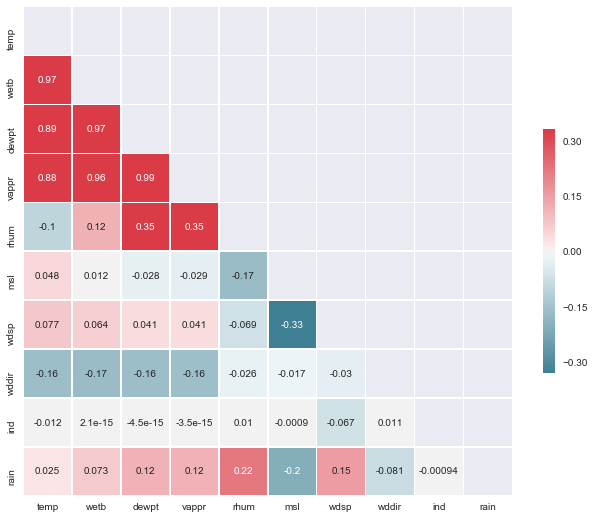

In [6]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

So we want to predict windspeeds. The only slightly correlated feature is the mean sea level pressure, because reasons! These low correlations do not really bode well for a ml algoritm but hopefully we can find some hidden activity here.
Not all is lost, we would not expect wind direction (in degrees) and wind speed to have an immediately obvious correlation

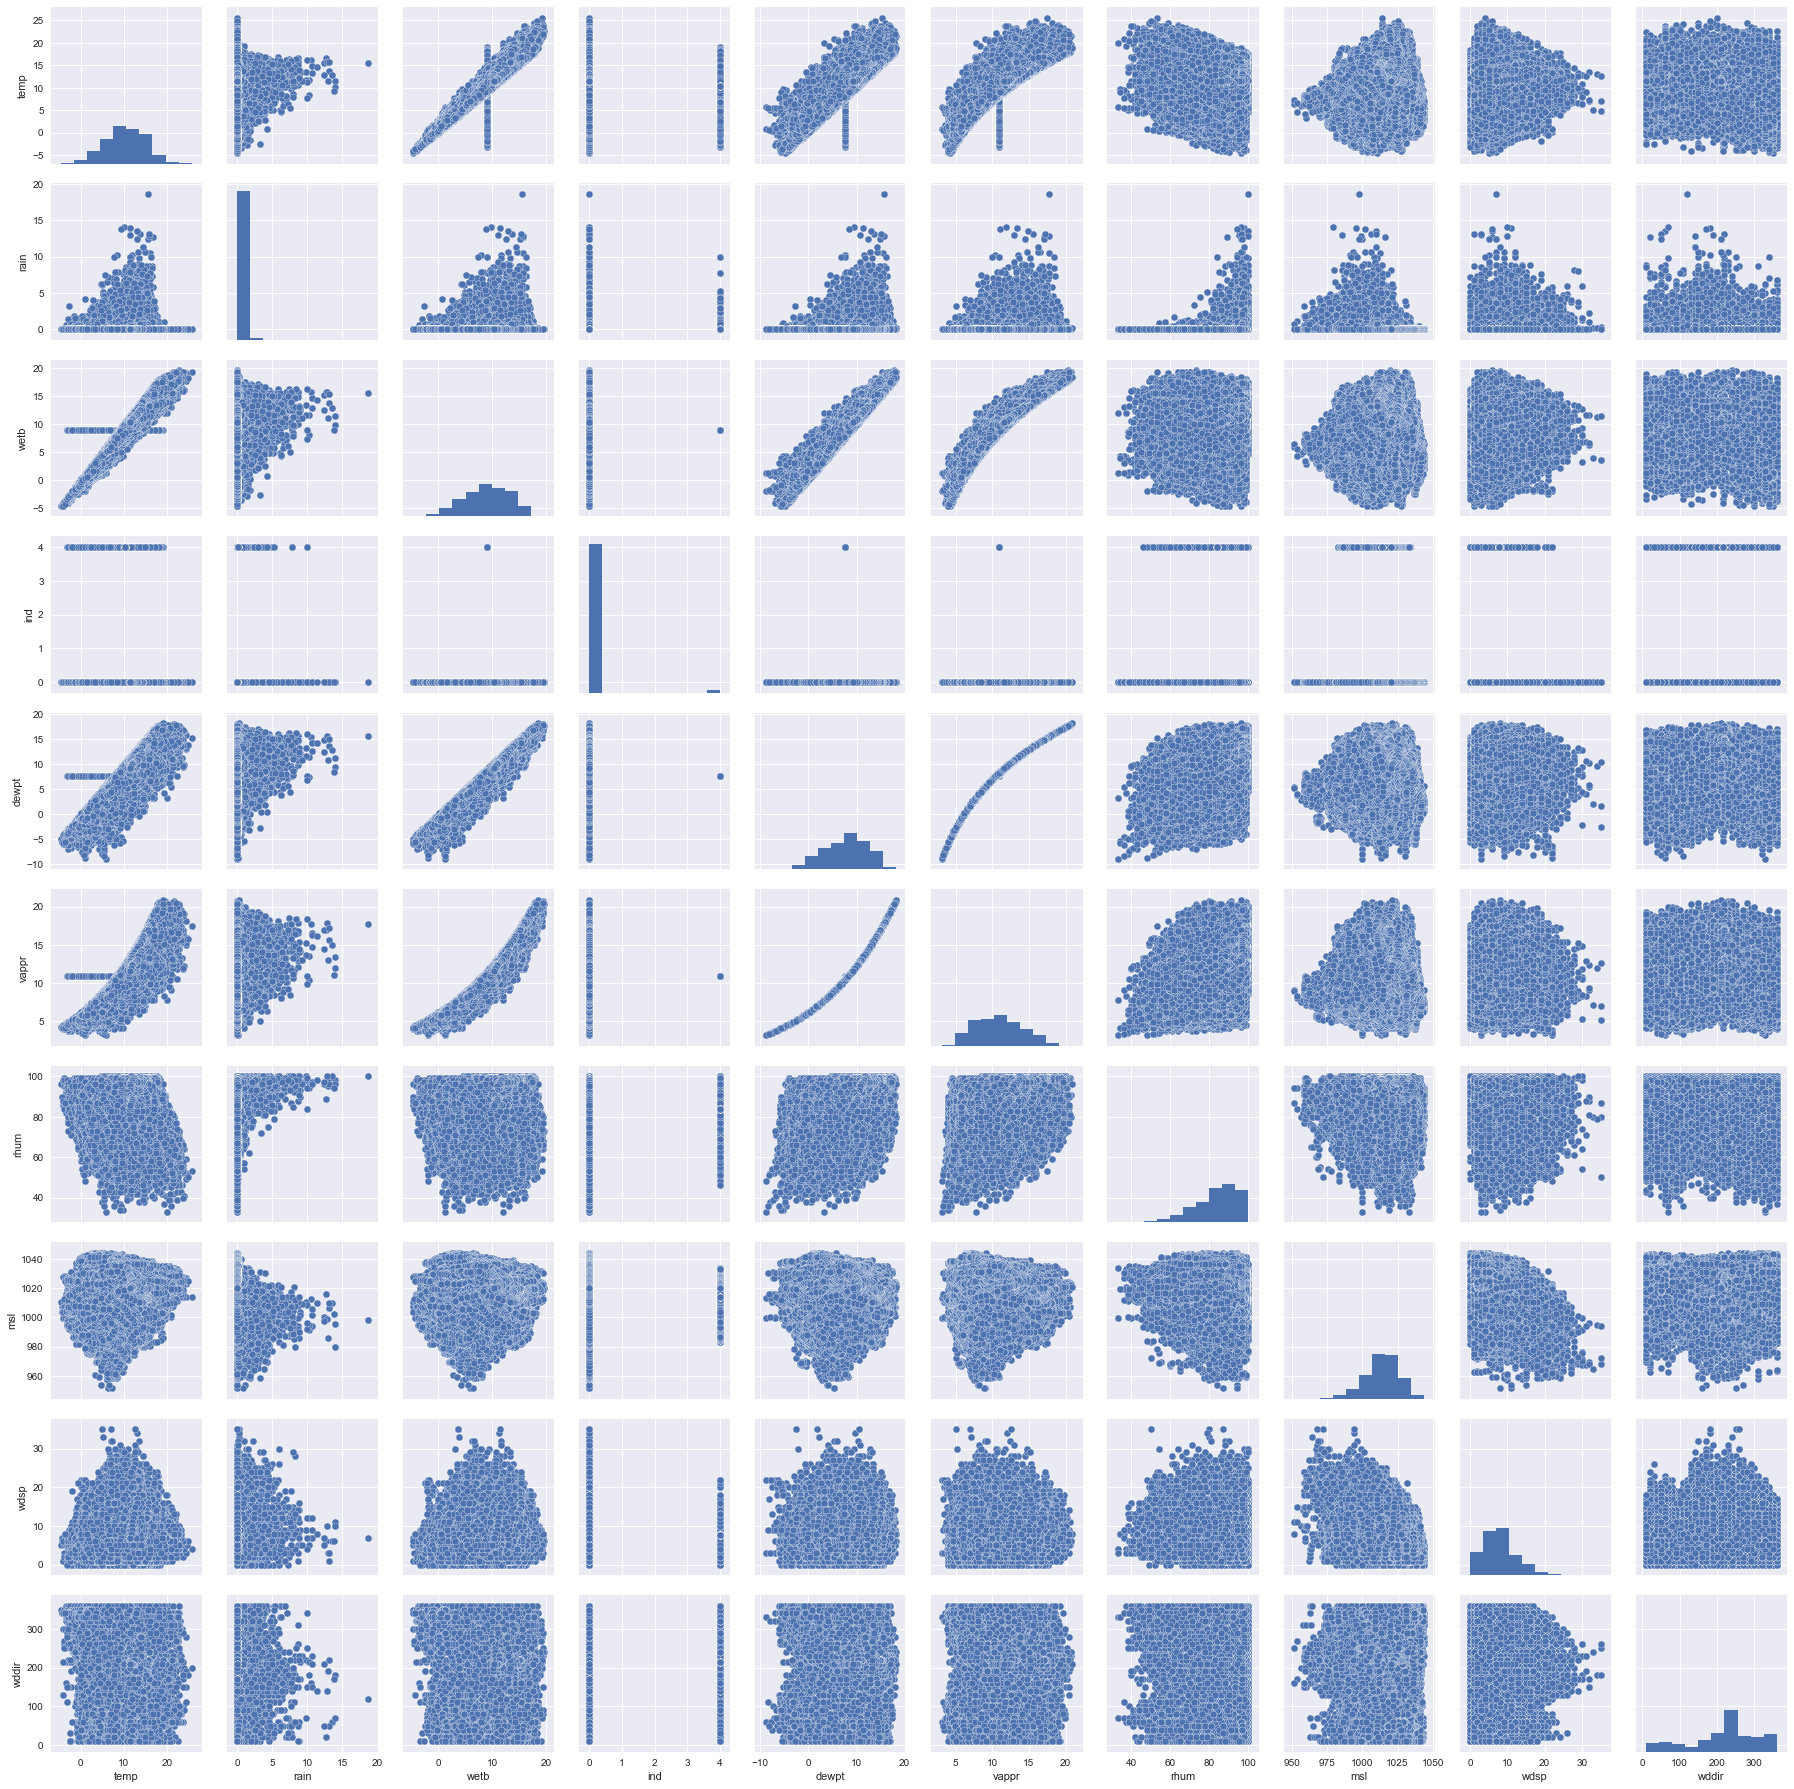

In [7]:
sns.pairplot(df[['temp','rain','wetb','ind','dewpt','vappr','rhum','msl','wdsp','wddir']], size = 2.5)


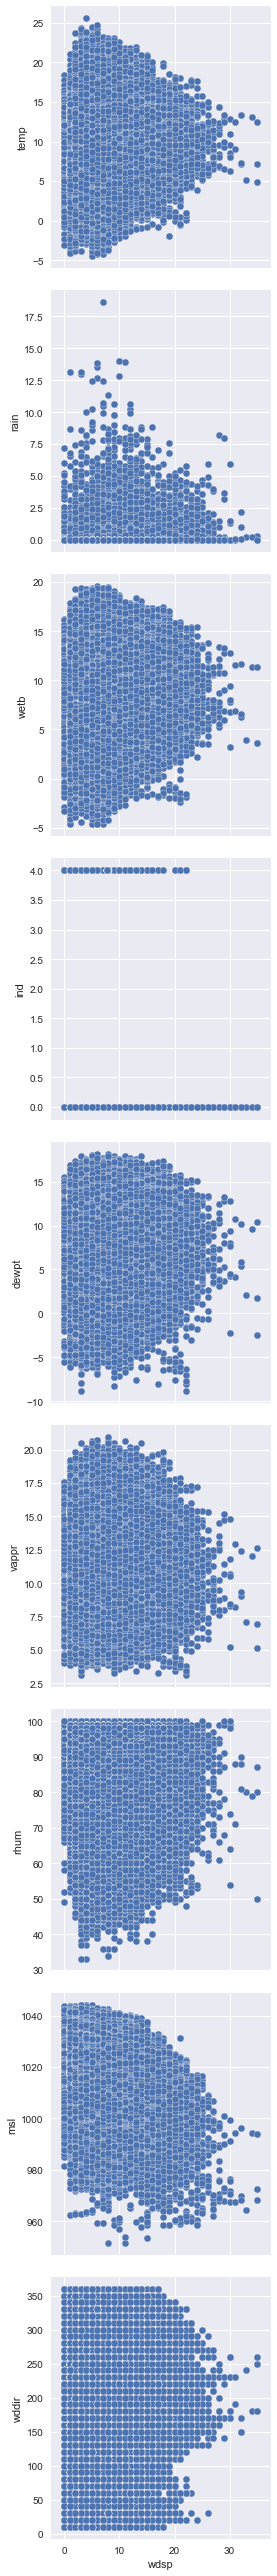

In [8]:
sns.set()
independ_cols=['temp','rain','wetb','ind','dewpt','vappr','rhum','msl','wddir']
sns.pairplot(data=df, x_vars=['wdsp'],y_vars=independ_cols, size = 4)
plt.show();

Some interesting stuff here, high wind speeds seem to occur in a range of approx 120 - 300. A 180 degree bias for one direction!? It's windier going south, I think!? This bias could, however be due to the wind simply blowing in that direction more often.
The correlation of the msl value is captured here well.

In [9]:
#ind doesnt seem to know to do anything but say "ZERO" so it can go away!
df = df.drop('ind',axis=1)

In [10]:
df.head()

,date,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,rain
0,01/01/2005 01:00,7.8,7.4,7.0,10.0,94.0,1022.9,5.0,210.0,0.119064
1,01/01/2005 02:00,8.6,8.1,7.7,10.5,94.0,1022.4,5.0,220.0,0.000000
2,01/01/2005 03:00,8.5,8.0,7.4,10.3,93.0,1021.6,7.0,230.0,0.000000
3,01/01/2005 04:00,8.9,8.4,7.9,10.6,93.0,1021.0,8.0,230.0,0.000000
4,01/01/2005 05:00,9.2,8.7,8.2,10.9,93.0,1019.8,8.0,220.0,0.000000


In [11]:
dataset = df.values

We will not use the timestamps (for now) despite the fact they could be a rich source of info!

In [12]:
X=np.c_[dataset[:,1:7],dataset[:,8]]
Y=dataset[:,7]

In [13]:
def make_model(model, xs, ys):
    regr=model
    
    X_train, X_test, Y_train, Y_test = train_test_split(xs, ys, test_size=0.1)
    regr.fit(X_train, Y_train)
    wind_pred = regr.predict(X_test)
    
    
    # The mean squared error
    print("Mean squared error: %.2f"% mean_squared_error(Y_test, wind_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(Y_test, wind_pred))
    print("Model is: {}".format(model))
    
    # Plot outputs
    plt.plot(Y_test[:150],  color='red',label='Real data')
    plt.plot(wind_pred[:150],color='blue',label='Predicted')
    plt.ylabel("Wind speed in knots")
    plt.legend()

Mean squared error: 11.81
Variance score: 0.37
Model is: BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


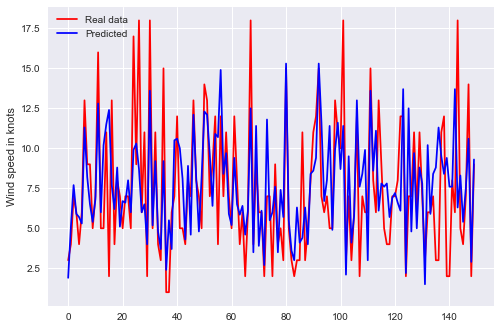

In [14]:
make_model(BaggingRegressor(), X, Y)

Mean squared error: 16.35
Variance score: 0.14
Model is: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


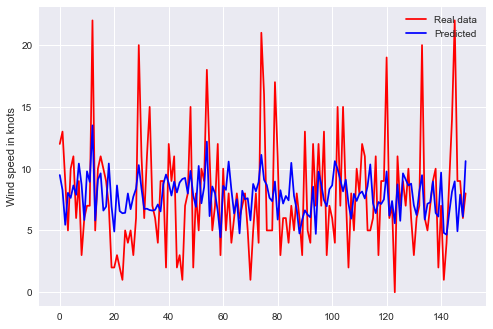

In [15]:
make_model(LinearRegression(), X, Y)

Mean squared error: 11.98
Variance score: 0.34
Model is: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


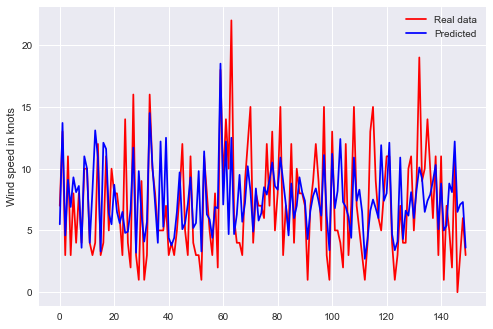

In [16]:
make_model(RandomForestRegressor(), X, Y)

Soo.. Can we predict the future in Wexford? Not really no.

But the performance of the models is definitely interesting.